Dominic Hewitt do6743he-s

## Import modules

In [1]:
import geopandas as gpd
import fiona
import rasterio
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
import numpy as np

## Load and check data

First I must merge las files into a single file called 'point_cloud.las'.

In [2]:
!pdal merge IC13.las IC21.las IC33.las IC37.las IC50.las IC63.las IC14.las IC24.las IC34.las IC38.las IC51.las IC67.las IC19.las IC25.las IC35.las IC48.las IC52.las IC20.las IC32.las IC36.las IC49.las IC53.las point_cloud.las

A good idea to check the info for first point.

In [3]:
!pdal info point_cloud.las -p 0

{
  "file_size": 1434970601,
  "filename": "point_cloud.las",
  "now": "2021-06-12T10:00:17+0200",
  "pdal_version": "2.2.0 (git-version: 3dd320)",
  "points":
  {
    "point":
    {
      "Blue": 0,
      "Classification": 2,
      "EdgeOfFlightLine": 0,
      "GpsTime": -15721194.08,
      "Green": 0,
      "Intensity": 101,
      "NumberOfReturns": 1,
      "PointId": 0,
      "PointSourceId": 1,
      "Red": 0,
      "ReturnNumber": 1,
      "ScanAngleRank": -6,
      "ScanDirectionFlag": 0,
      "UserData": 160,
      "X": 267998.77,
      "Y": 3097999.28,
      "Z": 1043.42
    }
  },
  "reader": "readers.las"
}


## Create DTM raster

To use certain modules in Pdal, the perameters need to be provided in JSON format. Below is the contents of the file I created for extracting the ground points and converting to Geotiff 

In [ ]:
# pipeline jspn file for extraction and conversion

'''[
    "point_cloud.las",
    {a
        "type":"filters.smrf",
        "window":33,
        "slope":1.0,
        "threshold":0.15,
        "cell":1.0
    },
    {
        "type":"filters.range",
        "limits":"Classification[2:2]"
    },
    {
        "type":"writers.gdal",
        "filename":"dtm.tif",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "window_size":3,
        "resolution":1.0
    }
]'''

Next I used the following command for extraction and converstion

In [5]:
!pdal pipeline dtm_pipeline.json

...and then to  fill/ interpolate the no data values using GDAL.

In [6]:
!gdal_fillnodata.py dtm.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Now to load and render the raster.

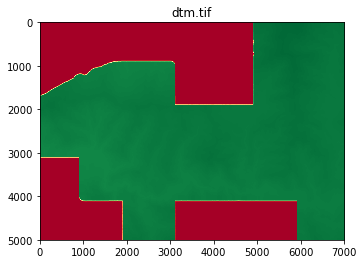

In [7]:
dtm = rasterio.open('dtm.tif')
dtm = dtm.read(1).astype(float)

plt.imshow(dtm, cmap='RdYlGn')
plt.title('dtm.tif')
plt.show()


The above figure dosent look right, its most likely due to the image being stretched between the min and max values.
To check, I looked at the distribution histogram.

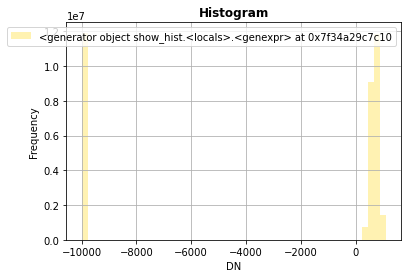

In [8]:
show_hist(dtm, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3)
plt.show()

Above I can see there are values (likely as no data) at around -9999.
So in the next step i will convert these to a NoData value and check the distribution again

In [9]:
dtm[dtm < 0] = np.nan

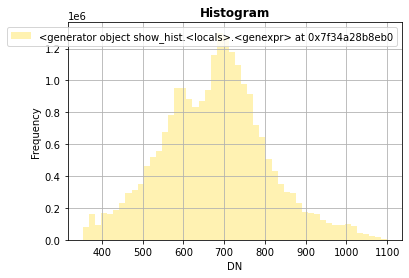

In [10]:
show_hist(dtm, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3)
plt.show()

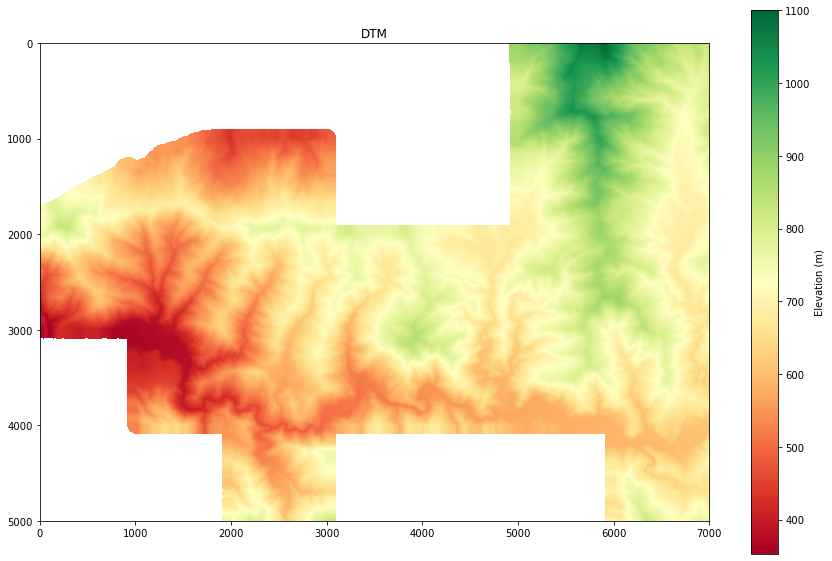

In [11]:
plt.figure(figsize = (15,10))
plt.imshow(dtm, cmap="RdYlGn")
plt.colorbar(label='Elevation (m)')
plt.title('DTM')
plt.show()

For interperatabiltiy, I added a hillshade effect and also overlayed the original DTM raster.

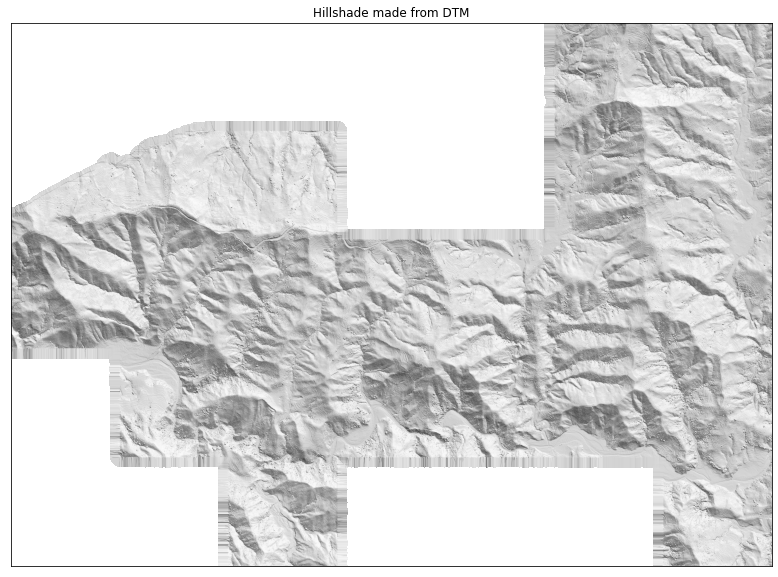

In [12]:
hillshade = es.hillshade(dtm)

ep.plot_bands(
    hillshade,
    cbar=False,
    title="Hillshade made from DTM",
    figsize=(15, 10),
)
plt.show()

...and overlayed the raster.

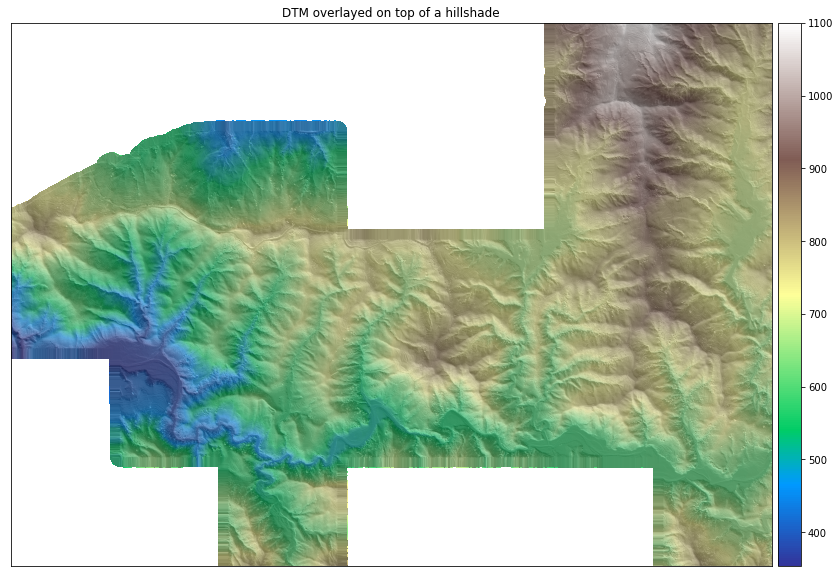

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
ep.plot_bands(
    dtm,
    ax=ax,
    cmap="terrain",
    title="DTM overlayed on top of a hillshade",
)
ax.imshow(hillshade, cmap="Greys", alpha=0.5)
plt.show()

## Create DSM

Again I needed to create a JSON file with the peramaters and run the required comamnds. Below is the content of the file.

In [ ]:
# pipeline json file for extraction and conversion

'''[
    "point_cloud.las",
    {
        "type":"filters.smrf",
        "window":33,
        "slope":1.0,
        "threshold":0.15,
        "cell":1.0
    },
    {
        "type":"filters.range",
        "limits":"Classification[1:1]"
    },
    {
        "type":"writers.gdal",
        "filename":"dsm.tif",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "window_size":3,
        "resolution":1.0
    }
]'''

In [15]:
# command for extraction and converstion
!pdal pipeline dsm_pipeline.json

In [16]:
#use gdal to fill/ interpolate the no data values
!gdal_fillnodata.py dsm.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Here there is the same issue with no data as with the DTM, so I converted the values -9999 to NoData after loading and rendered the result

In [17]:
dsm = rasterio.open('dsm.tif')
dsm = dsm.read(1).astype(float)

In [18]:
dsm[dsm < 0] = np.nan

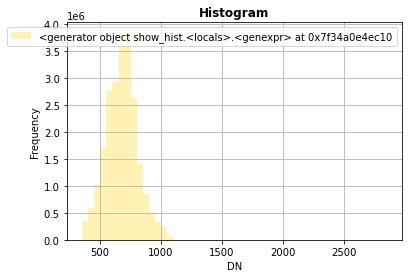

In [19]:
show_hist(dsm, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3)
plt.show()

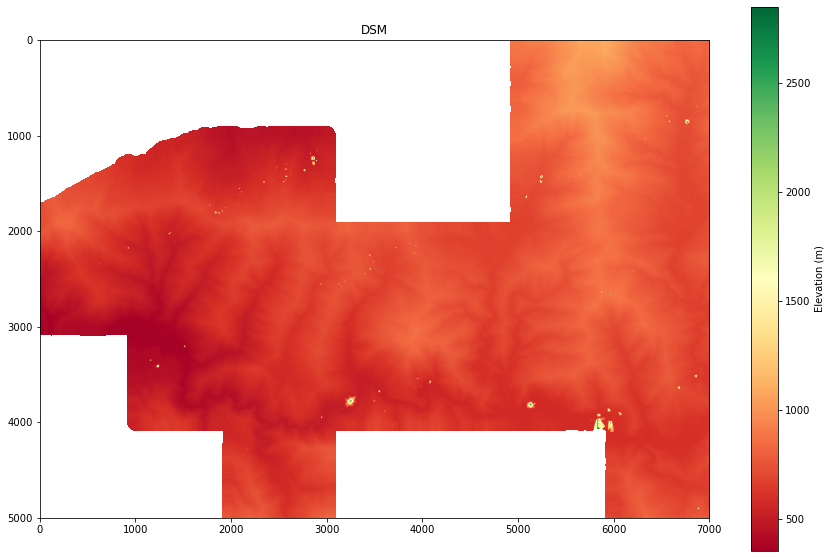

In [20]:
plt.figure(figsize = (15,10))
plt.imshow(dsm, cmap="RdYlGn")
plt.title('DSM')
plt.colorbar(label='Elevation (m)')
plt.show()

... and added the hillshade again

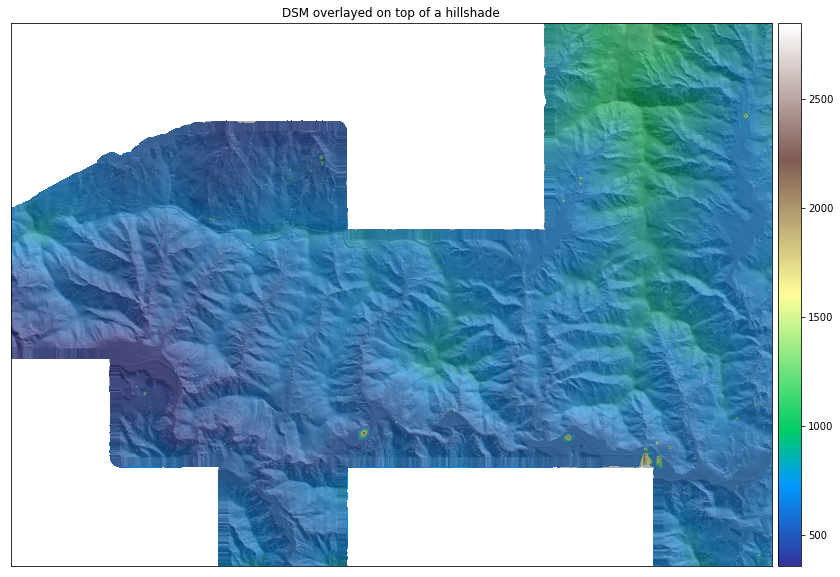

In [21]:
hillshade = es.hillshade(dsm)

fig, ax = plt.subplots(figsize=(15, 10))
ep.plot_bands(
    dsm,
    ax=ax,
    cmap="terrain",
    title="DSM overlayed on top of a hillshade",
)
ax.imshow(hillshade, cmap="Greys", alpha=0.5)
plt.show()

## Create the CHM

As the rasters are stored as numpy arrays, I can calculate the CHM with the simple formular below and then removed the values below 0 and above 40 before rendering the result and adding a hillshade effect.

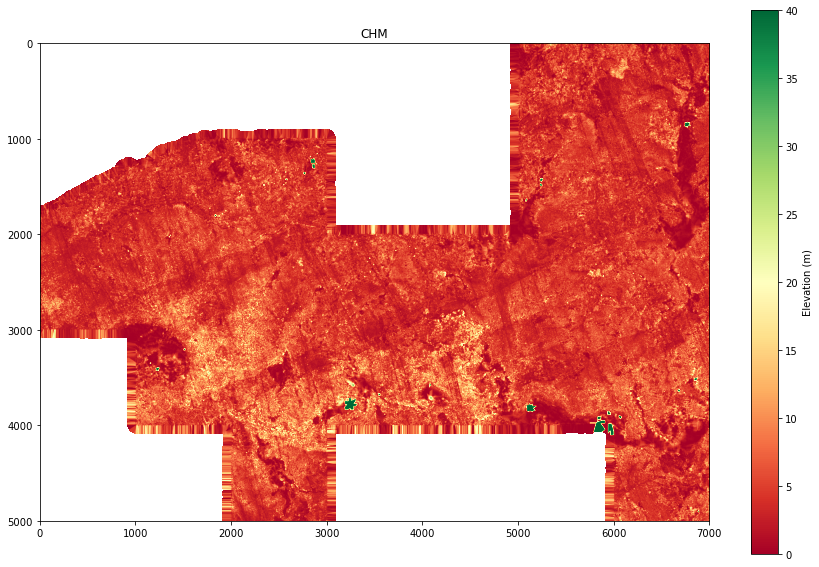

In [33]:
chm = dsm-dtm

chm = np.clip(chm, 0, 40)

plt.figure(figsize = (15,10))
plt.imshow(chm, cmap="RdYlGn")
plt.title('CHM')
plt.colorbar(label='Elevation (m)')
plt.show()

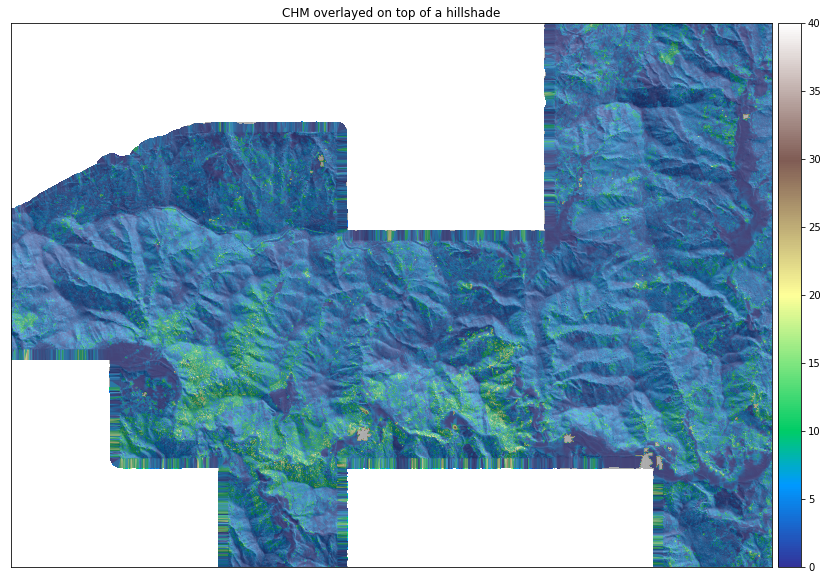

In [23]:
hillshade = es.hillshade(chm)

fig, ax = plt.subplots(figsize=(15, 10))
ep.plot_bands(
    chm,
    ax=ax,
    cmap="terrain",
    title="CHM overlayed on top of a hillshade",
)
ax.imshow(hillshade, cmap="Greys", alpha=0.5)
plt.show()

In [24]:
#save as .tif

with rasterio.open('dsm.tif') as src_dataset:

    profile = src_dataset.profile

    profile.update(
        count=1,
        crs='EPSG:32645',
        compress='lzw')

    with rasterio.open('chm.tif', 'w', **profile) as dst:
        dst.write(chm, 1)

## Clip to shapefile extent

Finally to clip the raster to the extent required for further anaysis I first had a look at the shapefile...

In [25]:
clip_extent = gpd.read_file('/home/dom/Documents/uni/MAP/Forest_Carbon/Digital_image_and_shapefile/Selected_CF.shp')
clip_extent

ID         AREA  PERIMETER  HECTARES             NAME  plot_numbe  \
0   0   508447.599   4580.829    50.845       Shikhar CF           5   
1   0   835757.148   7335.233    83.576     Birenchok CF           8   
2   0   500355.751   5776.863    50.036     Chisapani CF           5   
3   0   922692.028   6245.162    92.269        Kuwadi CF           9   
4   0  2707130.210  35123.522   270.713  Ludi Damgade CF          27   

   plot_more                                           geometry  
0          8  POLYGON ((265420.779 3094483.867, 265419.738 3...  
1         13  MULTIPOLYGON (((262681.505 3095505.697, 262682...  
2          8  POLYGON ((264807.559 3094674.572, 264811.489 3...  
3         15  POLYGON ((264467.688 3095682.522, 264465.396 3...  
4         43  MULTIPOLYGON (((267672.382 3095523.268, 267666...

<AxesSubplot:>

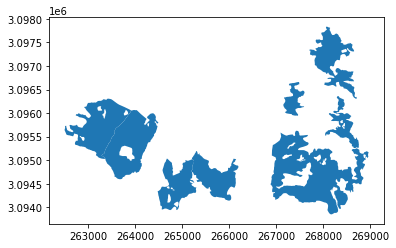

In [26]:
clip_extent.plot()

cropped the raster to the shapefiles geoemtry...

In [27]:
# Read Shape file
with fiona.open("/home/dom/Documents/uni/MAP/Forest_Carbon/Digital_image_and_shapefile/Selected_CF.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# read imagery file
with rasterio.open("chm.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

# Save clipped imagery
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("chm_mask.tif", "w", **out_meta) as chm_mask:
    chm_mask.write(out_image)

again fixed the NoData values and rendered the result.

In [28]:
chm_mask = rasterio.open('chm_mask.tif')
chm_mask = chm_mask.read(1).astype(float)
chm_mask[chm_mask < 0] = np.nan

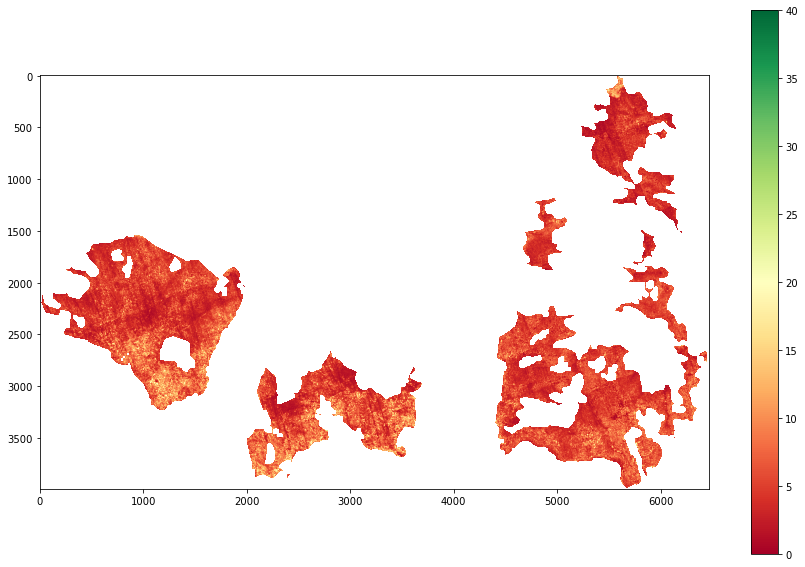

In [29]:
plt.figure(figsize = (15,10))
plt.imshow(chm_mask, cmap="RdYlGn")
plt.colorbar()
plt.show()

Finally I compared the result to the RGB file.

In [30]:
img = rasterio.open('/home/dom/Documents/uni/MAP/Forest_Carbon/Digital_image_and_shapefile/cf_ortho1.tif')
img = img.read()

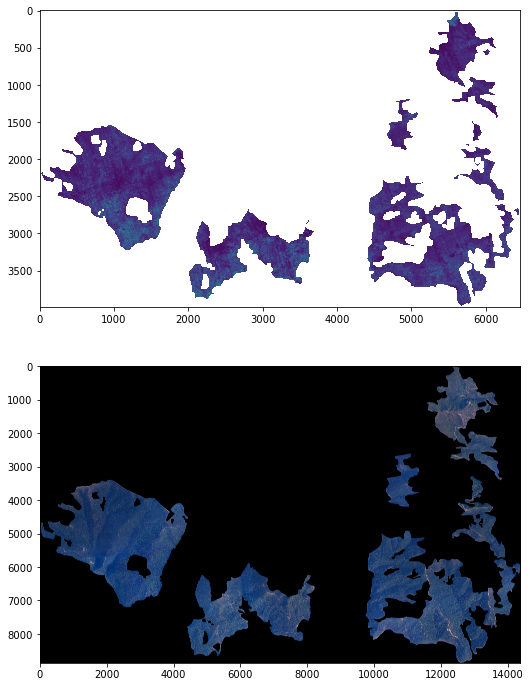

In [31]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12,12))
show(chm_mask, ax=ax)
show(img, ax=ax2)
plt.show()

Although the CHM appears slightly different, I also compared these files in QGIS and they appear the same. Therefore I think it just the rendering by matplotlib shown above.